# 🏆 Tydzień 10, Dzień 6: Projekt - AI Trading Bot Backtest

To finałowy projekt modułu Algotrading.
Przeprowadzimy profesjonalny backtest strategii **Momentum + Trend** na 5-letniej historii Bitcoina.

**Elementy projektu:**
1.  **Strategia Hybrydowa:** Łączymy RSI (Momentum) z SMA (Filtr Trendu).
2.  **Optymalizacja:** Znajdziemy najlepsze parametry (Grid Search).
3.  **Stress Test:** Nałożymy na wyniki realne prowizje i poślizgi.
4.  **Raport:** Porównamy wyniki z "Buy & Hold".

---
### 🛠️ 1. Setup i Dane

Pobieramy dane BTC z długiego okresu (Hossa i Bessa).

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from backtesting import Backtest, Strategy
import warnings

# Ignoruj konkretny komunikat z biblioteki backtesting
warnings.filterwarnings("ignore", message="Jupyter Notebook detected")

# Wyłączamy ostrzeżenia (w tym to o Jupyterze)
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# 1. Pobieranie danych (5 lat)
ticker = "BTC-USD"
start_date = "2020-01-01"
end_date = "2025-01-01"

print(f"📥 Pobieranie {ticker} ({start_date} - {end_date})...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)

# 2. Czyszczenie
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data.rename(columns={"Open": "Open", "High": "High", "Low": "Low", "Close": "Close", "Volume": "Volume"})
data.index = data.index.tz_localize(None)
data = data.dropna()

print(f"✅ Dane gotowe: {len(data)} dni handlowych.")

📥 Pobieranie BTC-USD (2020-01-01 - 2025-01-01)...
✅ Dane gotowe: 1827 dni handlowych.


### 🧠 2. Strategia Hybrydowa (Trend + Momentum)

Czyste RSI często daje fałszywe sygnały w silnym trendzie spadkowym (kupujesz "dołek", a on spada dalej).
Dlatego dodamy **Filtr Trendu (SMA 200)**.

**Logika:**
1.  **KUPUJ tylko gdy:** RSI jest niskie (wyprzedanie) **ORAZ** Cena jest powyżej SMA 200 (Długoterminowy trend wzrostowy).
    *   *Zasada: "Kupuj dołki, ale tylko w hossie".*
2.  **SPRZEDAWAJ gdy:** RSI jest wysokie (wykupienie) **LUB** Cena spadnie poniżej SMA 200 (Koniec trendu).

In [3]:
# Funkcje pomocnicze w czystym Pandas
def RSI(values, n):
    prices = pd.Series(values)
    delta = prices.diff()
    gain = delta.where(delta > 0, 0).rolling(n).mean()
    loss = -delta.where(delta < 0, 0).rolling(n).mean()
    rs = gain / (loss + 0.00001)
    return (100 - (100 / (1 + rs))).values

def SMA(values, n):
    return pd.Series(values).rolling(n).mean().values

class HybridStrategy(Strategy):
    # Parametry do optymalizacji
    rsi_period = 14
    rsi_lower = 30
    rsi_upper = 70
    sma_trend = 200
    
    def init(self):
        # Obliczamy wskaźniki
        self.rsi = self.I(RSI, self.data.Close, self.rsi_period)
        self.sma = self.I(SMA, self.data.Close, self.sma_trend)

    def next(self):
        price = self.data.Close[-1]
        
        # Warunki
        is_uptrend = price > self.sma[-1]
        is_oversold = self.rsi[-1] < self.rsi_lower
        is_overbought = self.rsi[-1] > self.rsi_upper
        
        # LOGIKA WEJŚCIA
        if not self.position:
            # Kupujemy tylko w trendzie wzrostowym na korekcie
            if is_uptrend and is_oversold:
                self.buy()
                
        # LOGIKA WYJŚCIA
        elif self.position:
            # Sprzedajemy na szczycie LUB gdy trend się załamie (Stop Loss trendowy)
            if is_overbought or not is_uptrend:
                self.position.close()

print("✅ Strategia Hybrydowa zdefiniowana.")

✅ Strategia Hybrydowa zdefiniowana.


### 🚀 3. Optymalizacja (Szukanie Złotego Środka)

Znajdźmy najlepsze parametry. Czy SMA 200 jest najlepsze? A może SMA 100?

In [4]:
# 1. Backtest Startowy (z prowizją!)
bt = Backtest(data, HybridStrategy, cash=100_000, commission=0.002) # 0.2% fee

print("⏳ Optymalizacja w toku...")

# 2. Grid Search
stats, heatmap = bt.optimize(
    rsi_lower=range(20, 45, 5),      # 20, 25, 30...
    rsi_upper=range(65, 85, 5),      # 65, 70, 75...
    sma_trend=range(100, 250, 50),   # 100, 150, 200
    maximize='Equity Final [$]',
    return_heatmap=True
)

print("\n🏆 NAJLEPSZE PARAMETRY:")
print(stats['_strategy'])
print(f"Zysk Końcowy: ${stats['Equity Final [$]']:,.2f}")
print(f"Return: {stats['Return [%]']:.2f}%")
print(f"Buy & Hold Return: {stats['Buy & Hold Return [%]']:.2f}%")

if stats['Return [%]'] > stats['Buy & Hold Return [%]']:
    print("✅ POBILIŚMY RYNEK! (Alpha > 0)")
else:
    print("❌ Rynek był lepszy (Buy & Hold wins).")

⏳ Optymalizacja w toku...


Backtest.optimize:   0%|          | 0/60 [00:00<?, ?it/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1727 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1627 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]


🏆 NAJLEPSZE PARAMETRY:
HybridStrategy(rsi_lower=40,rsi_upper=80,sma_trend=150)
Zysk Końcowy: $264,546.07
Return: 164.55%
Buy & Hold Return: 889.81%
❌ Rynek był lepszy (Buy & Hold wins).


### 📉 4. Stress Test (Brutalne Koszty)

Model wygląda dobrze? Sprawdźmy go w "piekle".
Dodajmy **Slippage (Poślizg)**. Załóżmy, że tracimy dodatkowe 0.2% na każdej transakcji przez opóźnienia i brak płynności.

Całkowity koszt = Prowizja (0.2%) + Slippage (0.2%) = **0.4%**.

In [5]:
# Pobieramy najlepsze parametry z optymalizacji
best_params = stats['_strategy']

# Tworzymy klasę z tymi parametrami
class BestHybrid(HybridStrategy):
    rsi_lower = best_params.rsi_lower
    rsi_upper = best_params.rsi_upper
    sma_trend = best_params.sma_trend

# Uruchamiamy "Brutalny Test"
# commission = 0.004 (0.4%)
bt_stress = Backtest(data, BestHybrid, cash=100_000, commission=0.004)
stats_stress = bt_stress.run()

print(f"--- WYNIK STRESS TESTU (Fee 0.4%) ---")
print(f"Zysk: ${stats_stress['Equity Final [$]']:,.2f}")
print(f"Zwrot: {stats_stress['Return [%]']:.2f}%")
print(f"Liczba transakcji: {stats_stress['# Trades']}")
print(f"Max Drawdown: {stats_stress['Max. Drawdown [%]']:.2f}%")

# Wykres
bt_stress.plot(open_browser=False)

Backtest.run:   0%|          | 0/1677 [00:00<?, ?bar/s]

--- WYNIK STRESS TESTU (Fee 0.4%) ---
Zysk: $234,070.03
Zwrot: 134.07%
Liczba transakcji: 15
Max Drawdown: -28.82%


GridPlot(id='p1396', ...)

### 📊 5. Heatmapa Stabilności

Czy nasza strategia to "szczęśliwy strzał", czy działa w szerokim zakresie?
Spójrzmy na mapę ciepła.

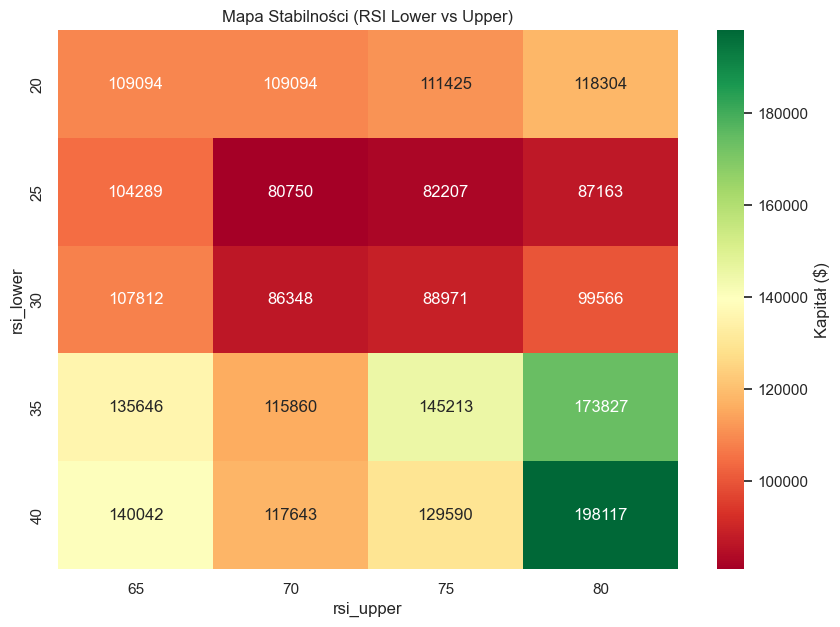

In [6]:
# Grupujemy heatmapę (spłaszczamy wymiar SMA)
hm_data = heatmap.groupby(['rsi_lower', 'rsi_upper']).mean().unstack()

plt.figure(figsize=(10, 7))
sns.heatmap(hm_data, cmap='RdYlGn', annot=True, fmt='.0f', cbar_kws={'label': 'Kapitał ($)'})
plt.title("Mapa Stabilności (RSI Lower vs Upper)")
plt.show()

## 🧠 Zadanie Domowe: Raport PDF

Masz wyniki. Twój szef (lub Ty sam) chce to mieć na papierze.

**Zadanie:**
1. Użyj wiedzy z Tygodnia 4 (ReportLab).
2. Wygeneruj plik PDF `Backtest_Report.pdf`.
3. Umieść w nim:
   *   Nazwę strategii i parametry.
   *   Wynik (Return %, Max Drawdown).
   *   Porównanie z Buy & Hold.
   *   (Opcjonalnie) Zapisz wykres `bt.plot()` jako obrazek i wklej go do PDF (to trudne z biblioteką Bokeh, więc możesz pominąć obrazek w zadaniu domowym i skupić się na tekście).

In [7]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
import os

# --- ROZWIĄZANIE ZADANIA DOMOWEGO: Raport PDF ---

print("📄 Generowanie raportu PDF...")

# 1. Konfiguracja ścieżki
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "../../"))
reports_dir = os.path.join(project_root, "data", "reports")
os.makedirs(reports_dir, exist_ok=True)

pdf_path = os.path.join(reports_dir, "Backtest_Report.pdf")

# 2. Przygotowanie danych (wyciągamy ze zmiennych z poprzednich komórek)
start_cash = 100_000
final_equity = stats_stress['Equity Final [$]']
net_profit = final_equity - start_cash
return_pct = stats_stress['Return [%]']
buy_hold_pct = stats_stress['Buy & Hold Return [%]']
drawdown = stats_stress['Max. Drawdown [%]']
trades = stats_stress['# Trades']
sharpe = stats_stress['Sharpe Ratio']

# Parametry zwycięskiej strategii
params_str = f"RSI: {best_params.rsi_lower}/{best_params.rsi_upper} | SMA Trend: {best_params.sma_trend}"

# 3. Rysowanie PDF
c = canvas.Canvas(pdf_path, pagesize=A4)
width, height = A4
y = height - 50 # Start od góry

# Tytuł
c.setFont("Helvetica-Bold", 22)
c.drawString(50, y, "Algorithmic Trading Report")
y -= 30
c.setFont("Helvetica", 12)
c.drawString(50, y, f"Asset: {ticker} | Interval: Daily | Strategy: Hybrid Momentum")
y -= 50

# Sekcja 1: Parametry
c.setFont("Helvetica-Bold", 14)
c.drawString(50, y, "1. Strategy Configuration")
y -= 20
c.setFont("Helvetica", 11)
c.drawString(70, y, f"Optimized Parameters: {params_str}")
y -= 15
c.drawString(70, y, "Simulation Type: Stress Test (0.2% fee + 0.2% slippage)")
y -= 40

# Sekcja 2: Wyniki Finansowe
c.setFont("Helvetica-Bold", 14)
c.drawString(50, y, "2. Performance Metrics")
y -= 20
c.setFont("Helvetica", 12)

# Lista metryk
metrics = [
    f"Initial Capital: ${start_cash:,.2f}",
    f"Final Equity:   ${final_equity:,.2f}",
    f"Net Profit:     ${net_profit:,.2f}",
    f"Total Return:   {return_pct:.2f}%",
    f"Max Drawdown:   {drawdown:.2f}% (Risk)",
    f"Sharpe Ratio:   {sharpe:.2f}",
    f"Total Trades:   {trades}"
]

for m in metrics:
    c.drawString(70, y, f"- {m}")
    y -= 20

y -= 20

# Sekcja 3: Benchmark
c.setFont("Helvetica-Bold", 14)
c.drawString(50, y, "3. Benchmark Comparison")
y -= 20
c.setFont("Helvetica", 12)
c.drawString(70, y, f"Buy & Hold Return: {buy_hold_pct:.2f}%")
y -= 20

# Werdykt
if return_pct > buy_hold_pct:
    c.setFillColorRGB(0, 0.6, 0) # Zielony
    verdict = "RESULT: OUTPERFORMED MARKET (Alpha Generated)"
else:
    c.setFillColorRGB(0.8, 0, 0) # Czerwony
    verdict = "RESULT: UNDERPERFORMED MARKET"

c.setFont("Helvetica-Bold", 12)
c.drawString(70, y, verdict)
c.setFillColorRGB(0, 0, 0) # Reset koloru

# Stopka
c.setFont("Helvetica-Oblique", 9)
c.drawString(50, 30, "Generated by Financial AI Architect Pipeline")

c.save()
print(f"✅ Raport PDF wygenerowany: {pdf_path}")

📄 Generowanie raportu PDF...
✅ Raport PDF wygenerowany: c:\Users\takze\OneDrive\Pulpit\project\financial-ai-engineering\data\reports\Backtest_Report.pdf
